# MNIST VIB Example

Here I demonstrate the Variational Information Bottleneck method on the MNIST dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [4]:
tf.reset_default_graph()

# Turn on xla optimization
config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
sess = tf.InteractiveSession(config=config)

In [5]:
images = tf.placeholder(tf.float32, [None, 2], 'images')
labels = tf.placeholder(tf.int64, [None], 'labels')
one_hot_labels = tf.one_hot(labels, 2)

In [7]:
layers = tf.contrib.layers
ds = tf.contrib.distributions

def encoder(images):
    net = layers.relu(2*images-1, 1024)
    net = layers.relu(net, 1024)
    params = layers.linear(net, 512)
    mu, rho = params[:, :256], params[:, 256:]
    encoding = ds.NormalWithSoftplusScale(mu, rho - 5.0)
    return encoding


def decoder(encoding_sample):
    net = layers.linear(encoding_sample, 2)
    return net

prior = ds.Normal(0.0, 1.0)

In [8]:
import math

with tf.variable_scope('encoder'):
    encoding = encoder(images)
    
with tf.variable_scope('decoder'):
    logits = decoder(encoding.sample())
    
with tf.variable_scope('decoder', reuse=True):
    many_logits = decoder(encoding.sample(12))

class_loss = tf.losses.softmax_cross_entropy(
    logits=logits, onehot_labels=one_hot_labels) / math.log(2)

BETA = 1e-3

info_loss = tf.reduce_sum(tf.reduce_mean(
    ds.kl_divergence(encoding, prior), 0)) / math.log(2)

total_loss = class_loss + BETA * info_loss

In [9]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(
    tf.argmax(logits, 1), labels), tf.float32))
avg_accuracy = tf.reduce_mean(tf.cast(tf.equal(
    tf.argmax(tf.reduce_mean(tf.nn.softmax(many_logits), 0), 1), labels), tf.float32))
IZY_bound = math.log(10, 2) - class_loss
IZX_bound = info_loss 

In [11]:
batch_size = 100
steps_per_batch = 10

In [12]:
global_step = tf.contrib.framework.get_or_create_global_step()
learning_rate = tf.train.exponential_decay(1e-4, global_step,
                                           decay_steps=2*steps_per_batch,
                                           decay_rate=0.97, staircase=True)
opt = tf.train.AdamOptimizer(learning_rate, 0.5)

ma = tf.train.ExponentialMovingAverage(0.999, zero_debias=True)
ma_update = ma.apply(tf.model_variables())

saver = tf.train.Saver()
saver_polyak = tf.train.Saver(ma.variables_to_restore())

train_tensor = tf.contrib.training.create_train_op(total_loss, opt,
                                                   global_step,
                                                   update_ops=[ma_update])

Instructions for updating:
Please switch to tf.train.get_or_create_global_step


In [13]:
tf.global_variables_initializer().run()

In [17]:
def evaluate():
    images_test, labels_test = prepare_data(1000)
    IZY, IZX, acc, avg_acc = sess.run([IZY_bound, IZX_bound, accuracy, avg_accuracy],
                             feed_dict={images: images_test, labels: labels_test})
    return IZY, IZX, acc, avg_acc, 1-acc, 1-avg_acc

In [18]:
def prepare_data(n_samples):
    data = []
    labels = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            data.append(np.random.multivariate_normal(mean = [0.0, 0.0], cov = np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
        else:
            #nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            nuisance = np.random.choice(3, 1)[0]
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = np.eye(2), size = 1).flatten())
            labels.append(0.0)
            
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

In [19]:
import sys

for epoch in range(200):
    for step in range(steps_per_batch):
        im, ls = prepare_data(batch_size)
        sess.run(train_tensor, feed_dict={images: im, labels: ls})
    print("{}: IZY={:.2f}\tIZX={:.2f}\tacc={:.4f}\tavg_acc={:.4f}\terr={:.4f}\tavg_err={:.4f}".format(
        epoch, *evaluate()))
    sys.stdout.flush()
    
savepth = saver.save(sess, '/tmp/mnistvib', global_step)

0: IZY=2.68	IZX=1622.74	acc=0.7990	avg_acc=0.7990	err=0.2010	avg_err=0.2010
1: IZY=2.64	IZX=1589.42	acc=0.7810	avg_acc=0.7800	err=0.2190	avg_err=0.2200
2: IZY=2.68	IZX=1543.68	acc=0.7940	avg_acc=0.7930	err=0.2060	avg_err=0.2070
3: IZY=2.67	IZX=1469.87	acc=0.7900	avg_acc=0.7900	err=0.2100	avg_err=0.2100
4: IZY=2.69	IZX=1355.78	acc=0.8030	avg_acc=0.8020	err=0.1970	avg_err=0.1980
5: IZY=2.69	IZX=1209.48	acc=0.7990	avg_acc=0.7960	err=0.2010	avg_err=0.2040
6: IZY=2.67	IZX=1007.43	acc=0.7980	avg_acc=0.7980	err=0.2020	avg_err=0.2020
7: IZY=2.63	IZX=815.55	acc=0.7620	avg_acc=0.7670	err=0.2380	avg_err=0.2330
8: IZY=2.61	IZX=668.01	acc=0.7730	avg_acc=0.7870	err=0.2270	avg_err=0.2130
9: IZY=2.62	IZX=618.56	acc=0.7710	avg_acc=0.7850	err=0.2290	avg_err=0.2150
10: IZY=2.58	IZX=618.19	acc=0.7700	avg_acc=0.7840	err=0.2300	avg_err=0.2160
11: IZY=2.62	IZX=580.26	acc=0.7880	avg_acc=0.8050	err=0.2120	avg_err=0.1950
12: IZY=2.54	IZX=574.15	acc=0.7540	avg_acc=0.7690	err=0.2460	avg_err=0.2310
13: IZY=2.62	IZ

In [20]:
# prepare test data
data_test = np.random.uniform(low = -1, high = 2, size = [50000, 2])

In [22]:
pred = sess.run(logits, feed_dict = {images: data_test})

/usr/lib/python3/dist-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
/home/philipp/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'interp'
  s)


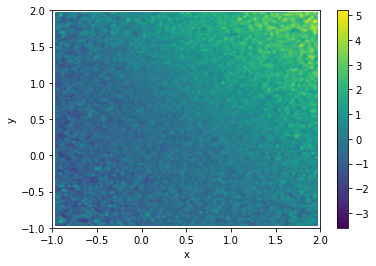

In [25]:
# plot a contour map
from matplotlib.mlab import griddata
xi = np.linspace(-1, 2, 100)
yi = np.linspace(-1, 2, 100)
zi = griddata(data_test[:, 0], data_test[:, 1], pred[:, 0], xi, yi, interp = "linear")

plt.contourf(xi, yi, zi, interp='linear', levels = 50)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()